In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sns.set(context='notebook', style='whitegrid', palette='deep', 
        font='sans-serif', font_scale=2, color_codes=True, rc=None)

import os, gc
os.listdir('DataSet/')

['Train.csv', 'Sample_submission.csv', 'Test.csv']

In [2]:
train = pd.read_csv("DataSet/Train.csv")
test  = pd.read_csv("DataSet/Test.csv")

train.shape, test.shape

((17521, 2395), (20442, 2394))

In [13]:
train['Col754']  = train['Col754'].replace('-',0).astype('float')
train['Col843']  = train['Col843'].replace('-',0).astype('float')

test['Col754']  = test['Col754'].replace('-',0).astype('float')
test['Col843']  = test['Col843'].replace('-',0).astype('float')


train.drop(['Col747','Col836'], axis=1, inplace=True)
test.drop(['Col747','Col836'], axis=1, inplace=True)


In [4]:
train.select_dtypes("object").isnull().sum()

Col1          0
Col747    16895
Col836    16897
dtype: int64

In [95]:
# for col in ['Col747','Col836']:
#     if col in no_imp_cat1:
#         print("found")

found
found


In [5]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

In [11]:
def train_lgb_model(X_train, y_train, X_valid, y_valid, features, param, X_test, num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds model, model_imp
    """
    _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
    _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))
    
    clf = lgb.train(param, _train, num_round, 
                    valid_sets = [_train, _valid], 
                    verbose_eval=200, 
                    early_stopping_rounds = 25)                  
    
    oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
    test_pred = clf.predict(X_test[features], num_iteration=clf.best_iteration)
    
    lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
    lgb_imp.columns = ['feature','imp']
    
    return oof, test_pred, clf, lgb_imp
    


    
def run_cv_lgb(train_df, target, test_df, leaves=None):

    param = {
        'bagging_freq'           : 5,
        'bagging_fraction'       : 0.33,
        'boost_from_average'     : 'false',
        'boost'                  : 'gbdt',
        'feature_fraction'       : 0.3,
        'learning_rate'          : 0.01,
        'max_depth'              : -1,
        'metric'                 : 'auc',
        'min_data_in_leaf'       : 100,
#         'min_sum_hessian_in_leaf': 10.0,
        'num_leaves'             : 30,
        'num_threads'            : 4,
        'tree_learner'           : 'serial',
        'objective'              : 'binary',
        'verbosity'              : 1,
        'lambda_l1'              : 0.01,
        'lambda_l2'              : 0.1
    }   
    if leaves is not None:
        param['num_leaves'] = leaves
        print("using leaves: ", param['num_leaves'])

    random_seed = 1234
    n_splits = 4
    num_round = 10000
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_lgb = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))

    clfs = []
    
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        
#         X_train.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)
#         X_valid.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)

        num_round = 10000
        oof, test_pred, clf, lgb_imp = train_lgb_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, param, 
                                                       test_df, num_round)
        lgb_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, lgb_imp], axis=0)
    
        oof_lgb[valid_index] = oof
        predictions[:,fold_] = test_pred
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        score = f1_score(y_valid, y_bin, average='weighted')
        print( "  f1 = ", score )
        print("="*60)
        gc.collect()
    print("="*60)
    
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')

    return clfs, feature_imp, oof_lgb, predictions




def train_cat_model(X_train, y_train, X_valid, y_valid, features, param, X_test, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    param['iterations'] = num_round
    
    _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

    watchlist = [_train, _valid]
    clf = CatBoostClassifier(**param)
    clf.fit(_train, 
            eval_set=watchlist, 
            verbose=200,
            use_best_model=True)
        
    oof  = clf.predict_proba(X_valid[features])[:,1]
    test_pred  = clf.predict_proba(X_test[features])[:,1]

    cat_imp = pd.DataFrame(data=[clf.feature_names_, 
                                 list(clf.feature_importances_)]).T
    cat_imp.columns = ['feature','imp']
    
    return oof, test_pred, clf, cat_imp


def run_cv_cat(train_df, target, test_df, depth):

    params = {
        'loss_function'         : "Logloss", 
        'eval_metric'           : "AUC",
        'random_strength'       : 1.5,
        'border_count'          : 128,
        'scale_pos_weight'      : 3.507,
        'depth'                 : depth, 
        'early_stopping_rounds' : 50,
        'random_seed'           : 1337,
        'task_type'             : 'CPU', 
#         'subsample'             = 0.7, 
        'iterations'            : 10000, 
        'learning_rate'         : 0.09,
        'thread_count'          : 4
    }


    ##########################
    n_splits = 4
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_cat = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        
        num_rounds = 10000
        oof, test_pred, clf, cat_imp = train_cat_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
    
        oof_cat[valid_index] = oof
        predictions[:,fold_] = test_pred
        
        cat_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, cat_imp], axis=0)
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        score = f1_score(y_valid, y_bin, average='weighted')
        print( "  f1 = ", score )
        print("="*60)
        gc.collect()
        
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')

    return clfs, feature_imp, oof_cat, predictions

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb


def train_xgb_model(X_train, y_train, X_valid, y_valid, features, param, X_test, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    _train = xgb.DMatrix(X_train[features], label=y_train, feature_names=list(features))
    _valid = xgb.DMatrix(X_valid[features], label=y_valid,feature_names=list(features))
    
    watchlist = [(_valid, 'valid')]
    clf = xgb.train(dtrain=_train, 
                    num_boost_round=num_round, 
                    evals=watchlist,
                    early_stopping_rounds=25, 
                    verbose_eval=200, 
                    params=param)
    
    valid_frame = xgb.DMatrix(X_valid[features],feature_names=list(features))
    oof  = clf.predict(valid_frame, ntree_limit=clf.best_ntree_limit)


    test_frame = xgb.DMatrix(X_test[features],feature_names=list(features))
    test_pred = clf.predict(test_frame, ntree_limit=clf.best_ntree_limit)

    
    xgb_imp = pd.DataFrame(data=[list(clf.get_fscore().keys()), 
                                 list(clf.get_fscore().values())]).T
    xgb_imp.columns = ['feature','imp']
    xgb_imp.imp = xgb_imp.imp.astype('float')
    
    return oof, test_pred, clf, xgb_imp


def run_cv_xgb(train_df, target, test_df, depth):

    features = train_df.columns
    params = {
        'eval_metric'     : 'auc',
        'seed'            : 1337,
        'eta'             : 0.05,
        'subsample'       : 0.7,
        'colsample_bytree': 0.5,
        'silent'          : 1,
        'nthread'         : 4,
        'Scale_pos_weight': 3.607,
        'objective'       : 'binary:logistic',
        'max_depth'       : depth,
        'alpha'           : 0.09
    }
    
    n_splits = 4
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_xgb = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        

        num_rounds = 10000
        oof, test_pred, clf, xgb_imp = train_xgb_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
        
        xgb_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, xgb_imp], axis=0)
    
        oof_xgb[valid_index] = oof
        predictions[:,fold_] = test_pred
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        score = f1_score(y_valid, y_bin, average='weighted')
        print( "  f1 = ", score )
        print("="*60)
        gc.collect()
    
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')


    return clfs, feature_imp, oof_xgb, predictions


In [7]:
# train = train.astype('category')
target = train['Col2']
tr_ids = train['Col1']
ts_ids = test['Col1']
train.drop(['Col1','Col2'], axis=1, inplace=True)
test.drop('Col1', axis=1, inplace=True)

In [14]:
clf_xgb1, imp_xgb1, oof_xgb1, predi_xgb1 = run_cv_xgb(train, target, test, depth=4)


(13140,) (4381,)
Fold 0
[0]	valid-auc:0.655269
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[106]	valid-auc:0.746571



ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Col702, Col733, Col742, Col763, Col791, Col813, Col822, Col831, Col852

In [6]:
clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train, target, test, depth=4)
# np.save('predictions/oof_cat1.npy', oof_cat1)
# np.save('predictions/predi_cat1.npy', predi_cat1)
# imp_cat1.to_csv('predictions/imp_cat1.csv', index=None)

(13140,) (4381,)
Fold 0
0:	test: 0.6533601	test1: 0.6624696	best: 0.6624696 (0)	total: 337ms	remaining: 56m 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7395700243
bestIteration = 140

Shrink model to first 141 iterations.
  auc =  0.7395700242872106
  f1 =  0.8758941469764685
(13141,) (4380,)
Fold 1
0:	test: 0.6497920	test1: 0.6421251	best: 0.6421251 (0)	total: 204ms	remaining: 34m
200:	test: 0.8068461	test1: 0.7407701	best: 0.7413815 (173)	total: 34s	remaining: 27m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7413815182
bestIteration = 173

Shrink model to first 174 iterations.
  auc =  0.7413815182279649
  f1 =  0.869382340454069
(13141,) (4380,)
Fold 2
0:	test: 0.6387032	test1: 0.6368147	best: 0.6368147 (0)	total: 265ms	remaining: 44m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7383116059
bestIteration = 141

Shrink model to first 142 iterations.
  auc =  0.7383116059067835
  f1 =  0.8681093760723454
(

In [7]:
from sklearn.metrics import classification_report as cr

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat1]
print(cr(target, ybins))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     15760
           1       0.36      0.25      0.30      1761

   micro avg       0.88      0.88      0.88     17521
   macro avg       0.64      0.60      0.61     17521
weighted avg       0.86      0.88      0.87     17521



In [8]:
oof_cat1

array([0.36037799, 0.09214856, 0.08133361, ..., 0.15862774, 0.0722821 ,
       0.35376729])

In [16]:
predi_cat1

array([[0.21770388, 0.28251102, 0.26560424, 0.27130489],
       [0.58307313, 0.65671624, 0.62806206, 0.65242171],
       [0.08907983, 0.11528582, 0.07638816, 0.0848317 ],
       ...,
       [0.13845611, 0.13968269, 0.14439405, 0.131282  ],
       [0.11772377, 0.13113019, 0.1154433 , 0.20803563],
       [0.57870479, 0.55980472, 0.67617686, 0.77288977]])

In [17]:
np.mean(predi_cat1, axis=1)

array([0.25928101, 0.63006828, 0.09139638, ..., 0.13845371, 0.14308322,
       0.64689403])

In [18]:
ybins = [1.0 if y > 0.5 else 0 for y in np.mean(predi_cat1, axis=1)]
# y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]

sub_cat1 = pd.DataFrame(data=pd.concat([ts_ids.reset_index(drop=True), pd.DataFrame(ybins)], axis=1))
sub_cat1.columns = ['Col1','Col2']
sub_cat1

,Col1,Col2
0,RIGD58ZWD,0.0
1,RIH660YDS,1.0
2,RIH660Q96,0.0
3,RIYDO15W1,0.0
4,RIYBGC1ZD,0.0
5,RIYBQ5SWR,0.0
6,RIYBQ5SD5,0.0
7,TI5HU5XY,0.0
8,TIYHGOSE,0.0
9,T90K61QJ,0.0


In [19]:
sub_cat1.to_csv('predictions/sub_cat1.csv', index=None)

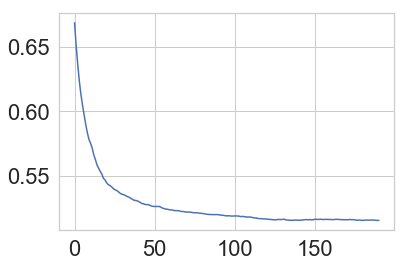

In [29]:
plt.plot(clf_cat1[0].evals_result_['validation_1']['Logloss'])

In [46]:
no_imp_cat1 = imp_cat1[imp_cat1.imp == 0]['feature'].values
clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train.drop(no_imp_cat1, axis=1), target, test.drop(no_imp_cat1, axis=1), depth=4)


(13140,) (4381,)
Fold 0
0:	test: 0.6511902	test1: 0.6595419	best: 0.6595419 (0)	total: 132ms	remaining: 21m 57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7430211679
bestIteration = 55

Shrink model to first 56 iterations.
  auc =  0.7430211678580061
  f1 =  0.8740968697108293
(13141,) (4380,)
Fold 1
0:	test: 0.5572453	test1: 0.5582135	best: 0.5582135 (0)	total: 112ms	remaining: 18m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7409797531
bestIteration = 73

Shrink model to first 74 iterations.
  auc =  0.7409797531149054
  f1 =  0.8670481824072024
(13141,) (4380,)
Fold 2
0:	test: 0.6302473	test1: 0.6302247	best: 0.6302247 (0)	total: 105ms	remaining: 17m 29s
200:	test: 0.8071700	test1: 0.7389654	best: 0.7398157 (189)	total: 20.7s	remaining: 16m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7408147785
bestIteration = 241

Shrink model to first 242 iterations.
  auc =  0.740814778495616
  f1 =  0.868962362504332

In [48]:
from sklearn.metrics import classification_report as cr

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat1]
print(cr(target, ybins))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     15760
           1       0.36      0.22      0.27      1761

   micro avg       0.88      0.88      0.88     17521
   macro avg       0.64      0.59      0.61     17521
weighted avg       0.86      0.88      0.87     17521



In [ ]:
             precision    recall  f1-score   support

           0       0.92      0.95      0.93     15760
           1       0.36      0.25      0.30      1761

   micro avg       0.88      0.88      0.88     17521
   macro avg       0.64      0.60      0.61     17521
weighted avg       0.86      0.88      0.87     17521



In [ ]:
clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train.drop(no_imp_cat1, axis=1), target, test.drop(no_imp_cat1, axis=1), depth=6)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat1]
print(cr(target, ybins))

In [8]:
import random, math

def grouping_cols(df, cat_percentage = 0.05, checking_itr = 10):
    cc, nc = [], []
    max_ = 0
    amount = int(df.shape[0]*cat_percentage)
    print(amount, "/", df.shape[0]," Used to differentiate num feature from cat feature")
    for col in df.columns:
        uni = df[col].unique().shape[0]
#         print(uni)
        max_ = max(max_, uni)
        if(uni <= amount):
            cc.append(col)
        else:
            nc.append(col)
        
    print("-----Filtered result after Ist stage-----")
    print("total cat cols: {}, total num cols: {}\n".format(len(cc), len(nc)))
    
    true_cat = []
    true_num = []
    for col in nc+cc:
        num = False
        if(df[col].dtype == 'object'):
            true_cat.append(col)
            continue
        for i in range(checking_itr):
            sample = np.random.choice(df[col].unique())
            if math.isnan(sample): continue
            if int(sample) != sample:
                num = True
        if num is True:
            true_num.append(col)
        else:
            true_cat.append(col)

    print("-----Filtered result after 2nd stage-----")
    print("total cat cols: {}, total num cols: {}".format(len(true_cat), len(true_num)))
    return cc, nc


In [9]:
cat_cols, num_cols = grouping_cols(train, cat_percentage=0.025)


438 / 17521  Used to differentiate num feature from cat feature
-----Filtered result after Ist stage-----
total cat cols: 1725, total num cols: 668

-----Filtered result after 2nd stage-----
total cat cols: 1639, total num cols: 754


In [59]:
# def factorize_cat(table, cat_cols=None):
#     print("=== Factorize Done ====")
#     for col in cat_cols:
#         table[col], _ = pd.factorize(table[col])
#     return table

# df = factorize_cat(df, cat_cols)

In [10]:
train1 = train.drop(no_imp_cat1, axis=1)
test1  = test.drop(no_imp_cat1, axis=1)

new_cat_cols = [col for col in cat_cols if col not in no_imp_cat1]
train1[new_cat_cols] = train1[new_cat_cols].astype("category")
test1[new_cat_cols] = test1[new_cat_cols].astype("category")
train1.shape, test1.shape

NameError: name 'no_imp_cat1' is not defined

In [112]:
gc.collect()

22015

In [61]:
clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train1, target, test1, depth=4)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat1]
print(cr(target, ybins))

(13140,) (4381,)
Fold 0
0:	test: 0.6511902	test1: 0.6595419	best: 0.6595419 (0)	total: 114ms	remaining: 19m 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7430211679
bestIteration = 55

Shrink model to first 56 iterations.
  auc =  0.7430211678580061
  f1 =  0.8740968697108293
(13141,) (4380,)
Fold 1
0:	test: 0.5572453	test1: 0.5582135	best: 0.5582135 (0)	total: 108ms	remaining: 18m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7409797531
bestIteration = 73

Shrink model to first 74 iterations.
  auc =  0.7409797531149054
  f1 =  0.8670481824072024
(13141,) (4380,)
Fold 2
0:	test: 0.6302473	test1: 0.6302247	best: 0.6302247 (0)	total: 117ms	remaining: 19m 31s
200:	test: 0.8071700	test1: 0.7389654	best: 0.7398157 (189)	total: 20.7s	remaining: 16m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7408147785
bestIteration = 241

Shrink model to first 242 iterations.
  auc =  0.740814778495616
  f1 =  0.8689623625043329


In [63]:
clf_cat2, imp_cat2, oof_cat2, predi_cat2 = run_cv_cat(train1, target, test1, depth=6)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat2]
print(cr(target, ybins))

(13140,) (4381,)
Fold 0
0:	test: 0.6702522	test1: 0.6581558	best: 0.6581558 (0)	total: 268ms	remaining: 44m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7431092234
bestIteration = 127

Shrink model to first 128 iterations.
  auc =  0.7431092233847854
  f1 =  0.8759306910222753
(13141,) (4380,)
Fold 1
0:	test: 0.5655123	test1: 0.5629127	best: 0.5629127 (0)	total: 243ms	remaining: 40m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.744643228
bestIteration = 114

Shrink model to first 115 iterations.
  auc =  0.7446432279649284
  f1 =  0.866465179602157
(13141,) (4380,)
Fold 2
0:	test: 0.6354518	test1: 0.6323102	best: 0.6323102 (0)	total: 322ms	remaining: 53m 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7323979003
bestIteration = 32

Shrink model to first 33 iterations.
  auc =  0.7323979003230272
  f1 =  0.8670967317676023
(13141,) (4380,)
Fold 3
0:	test: 0.6570216	test1: 0.6201465	best: 0.6201465 (0)	total: 23

In [66]:
len(new_cat_cols), len(cat_cols)

(892, 1725)

In [68]:
train.shape, train1.shape

((17521, 2393), (17521, 1360))

In [106]:
# train.select_dtypes("category")
# 'Col702', 'Col733', 'Col742', 'Col763', 'Col791', 'Col813', 'Col822', 'Col831', 'Col852'
train['Col702'].value_counts()

0.000000    1395
0.255551       2
0.442620       1
0.079860       1
0.069985       1
0.057143       1
0.058166       1
Name: Col702, dtype: int64

In [111]:
train[['Col702', 'Col733', 'Col742', 'Col763', 'Col791', 'Col813', 'Col822', 'Col831', 'Col852']].isnull().sum()

Col702    16119
Col733    16979
Col742    16708
Col763    15313
Col791    16117
Col813    17514
Col822    16985
Col831    16744
Col852    15347
dtype: int64

In [110]:
set(no_imp_cat1).intersection(set(['Col702', 'Col733', 'Col742', 'Col763', 'Col791', 'Col813', 'Col822', 'Col831', 'Col852']))

{'Col763', 'Col813', 'Col822', 'Col831', 'Col852'}

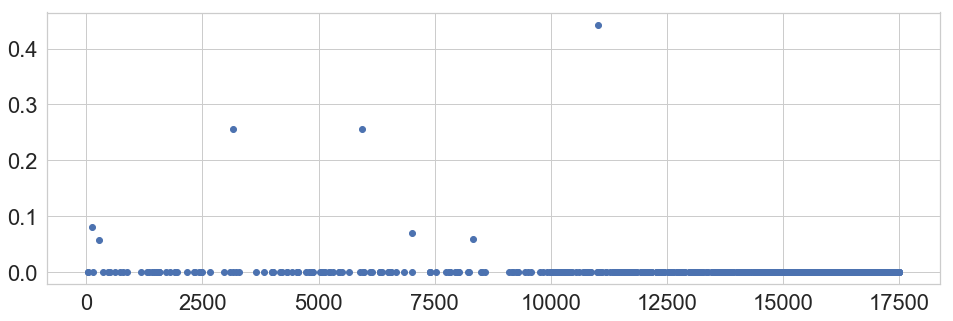

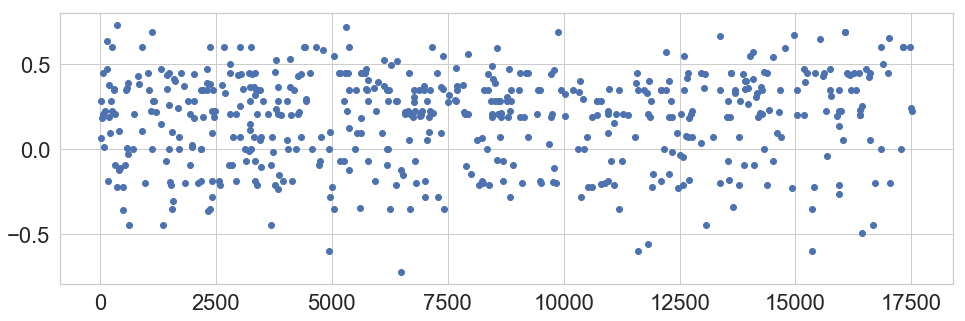

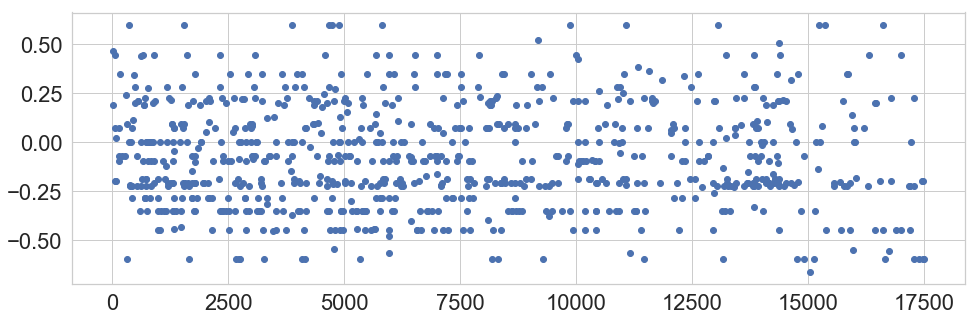

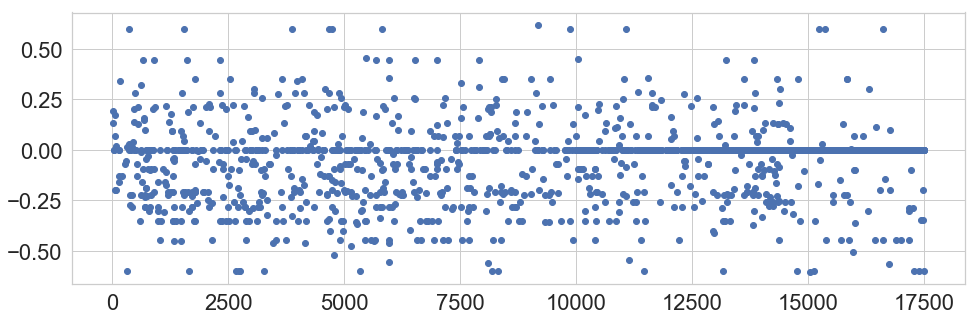

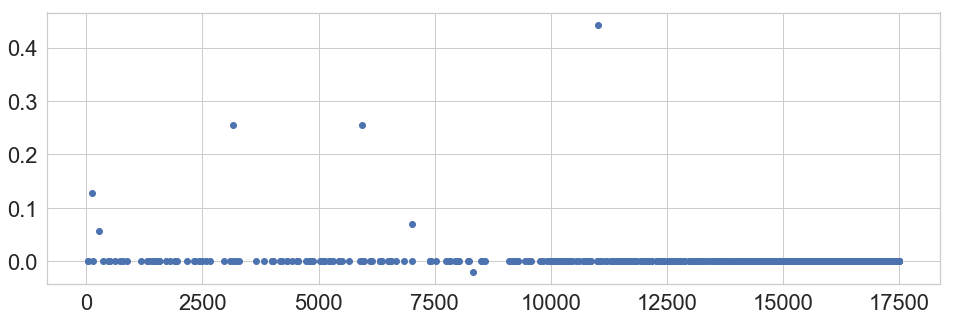

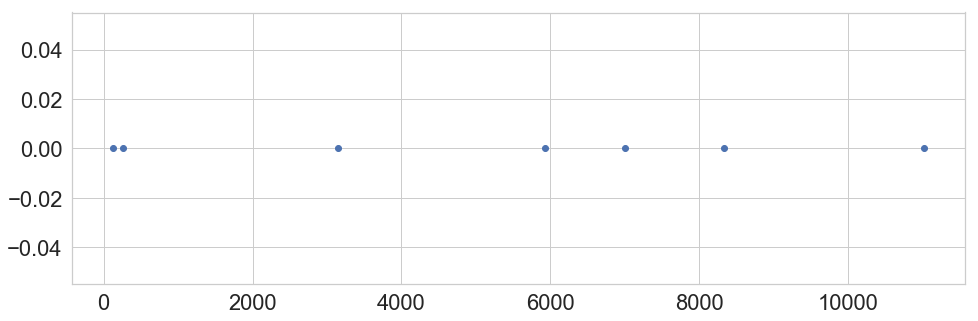

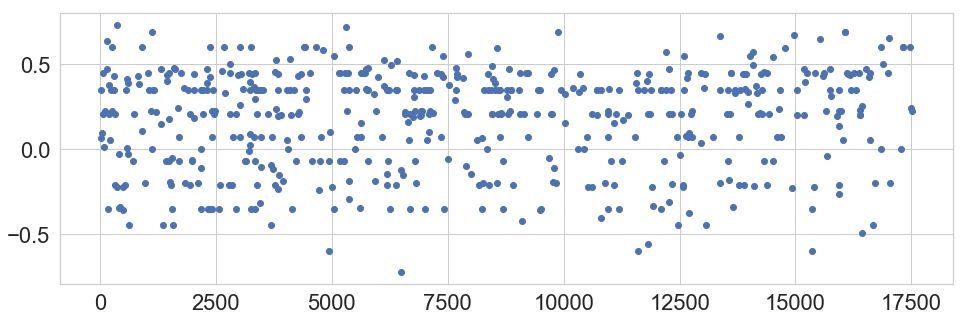

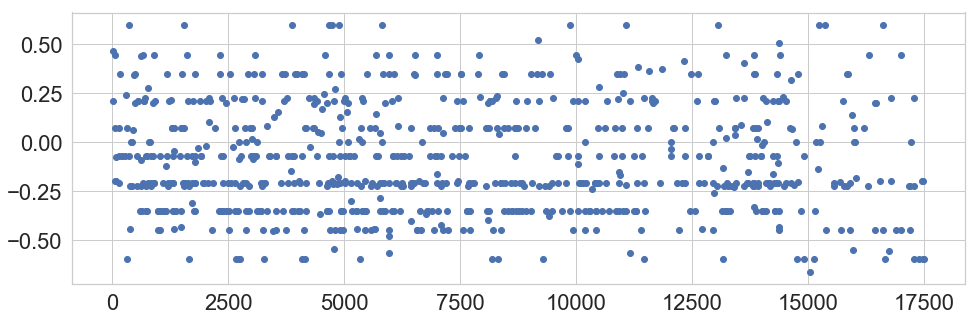

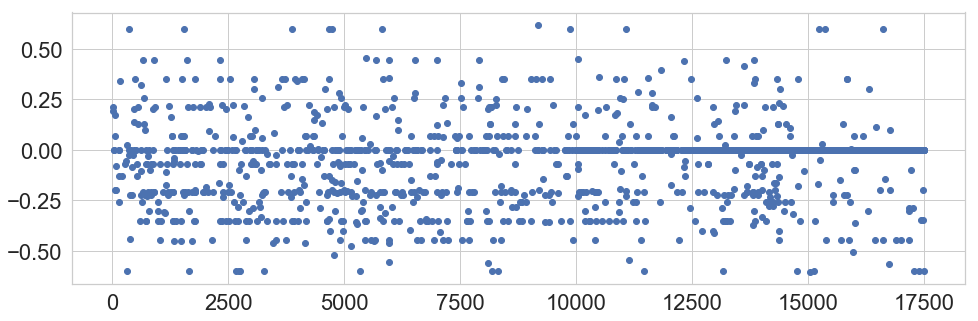

In [109]:
for col in ['Col702', 'Col733', 'Col742', 'Col763', 'Col791', 'Col813', 'Col822', 'Col831', 'Col852']:
    plt.figure(figsize=(16,5))
    plt.plot(train[col],'o')

In [105]:
gc.collect()

422

In [99]:
clf_lgb1, imp_lgb1, oof_lgb1, predi_lgb1 = run_cv_lgb(train, target, test, leaves=50)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_lgb1]
print(cr(target, ybins))

using leaves:  50
(13140,) (4381,)
Fold 0
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[74]	training's auc: 0.800229	valid_1's auc: 0.736953


ValueError: DataFrame.dtypes for data must be int, float or bool. Did not expect the data types in fields Col702, Col733, Col742, Col763, Col791, Col813, Col822, Col831, Col852

In [97]:
# train1[new_cat_cols] = train1[new_cat_cols].astype("category")
# test1[new_cat_cols] = test1[new_cat_cols].astype("category")


In [98]:
clf_lgb1, imp_lgb1, oof_lgb1, predi_lgb1 = run_cv_lgb(train1, target, test1, leaves=60)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_lgb1]
print(cr(target, ybins))

using leaves:  60
(13140,) (4381,)
Fold 0


ValueError: DataFrame.dtypes for data must be int, float or bool. Did not expect the data types in fields Col865, Col867, Col868, Col869, Col878, Col879, Col882, Col883, Col887, Col888, Col889, Col890, Col891, Col894, Col895, Col896, Col897, Col898, Col899, Col900, Col903, Col904, Col905, Col906, Col907, Col908, Col909, Col911, Col912, Col913, Col914, Col915, Col917, Col919, Col924, Col927, Col928, Col929, Col930, Col935, Col936, Col938, Col941, Col944, Col946, Col949, Col951, Col952, Col954, Col958, Col959, Col961, Col962, Col963, Col966, Col967, Col970, Col971, Col975, Col977, Col978, Col980, Col982, Col983, Col985, Col989, Col991, Col992, Col993, Col994, Col999, Col1000, Col1001, Col1006, Col1007, Col1008, Col1009, Col1010, Col1012, Col1013, Col1014, Col1015, Col1020, Col1021, Col1028, Col1029, Col1030, Col1032, Col1036, Col1037, Col1038, Col1040, Col1041, Col1042, Col1043, Col1044, Col1046, Col1047, Col1051, Col1053, Col1056, Col1057, Col1059, Col1060, Col1061, Col1062, Col1063, Col1064, Col1065, Col1069, Col1071, Col1074, Col1079, Col1082, Col1084, Col1087, Col1088, Col1089, Col1091, Col1092, Col1093, Col1094, Col1095, Col1097, Col1099, Col1103, Col1106, Col1107, Col1108, Col1109, Col1110, Col1113, Col1114, Col1116, Col1120, Col1121, Col1130, Col1131, Col1132, Col1135, Col1136, Col1137, Col1138, Col1141, Col1143, Col1144, Col1145, Col1146, Col1150, Col1151, Col1152, Col1154, Col1161, Col1162, Col1164, Col1167, Col1168, Col1172, Col1173, Col1174, Col1176, Col1179, Col1180, Col1181, Col1183, Col1184, Col1185, Col1186, Col1187, Col1188, Col1189, Col1192, Col1193, Col1197, Col1198, Col1199, Col1200, Col1202, Col1204, Col1205, Col1207, Col1208, Col1209, Col1211, Col1212, Col1213, Col1215, Col1217, Col1220, Col1222, Col1224, Col1227, Col1229, Col1230, Col1231, Col1232, Col1233, Col1234, Col1236, Col1238, Col1241, Col1242, Col1245, Col1246, Col1249, Col1258, Col1263, Col1266, Col1267, Col1268, Col1272, Col1277, Col1279, Col1281, Col1283, Col1287, Col1288, Col1290, Col1291, Col1292, Col1293, Col1294, Col1299, Col1302, Col1303, Col1304, Col1305, Col1309, Col1310, Col1311, Col1313, Col1315, Col1316, Col1317, Col1319, Col1321, Col1322, Col1330, Col1332, Col1333, Col1339, Col1340, Col1343, Col1344, Col1345, Col1346, Col1349, Col1351, Col1352, Col1354, Col1357, Col1360, Col1363, Col1364, Col1365, Col1367, Col1371, Col1373, Col1374, Col1375, Col1377, Col1380, Col1381, Col1383, Col1385, Col1386, Col1387, Col1389, Col1391, Col1393, Col1394, Col1395, Col1396, Col1398, Col1400, Col1402, Col1403, Col1406, Col1407, Col1408, Col1409, Col1410, Col1412, Col1413, Col1416, Col1418, Col1421, Col1422, Col1423, Col1425, Col1426, Col1428, Col1431, Col1432, Col1433, Col1439, Col1441, Col1442, Col1443, Col1444, Col1450, Col1451, Col1453, Col1454, Col1455, Col1456, Col1459, Col1464, Col1467, Col1469, Col1471, Col1477, Col1478, Col1479, Col1480, Col1485, Col1488, Col1489, Col1491, Col1496, Col1497, Col1498, Col1499, Col1500, Col1502, Col1503, Col1505, Col1506, Col1511, Col1512, Col1518, Col1519, Col1521, Col1522, Col1523, Col1524, Col1525, Col1527, Col1528, Col1531, Col1535, Col1538, Col1540, Col1541, Col1542, Col1544, Col1545, Col1550, Col1551, Col1552, Col1554, Col1556, Col1560, Col1564, Col1566, Col1571, Col1572, Col1573, Col1574, Col1575, Col1576, Col1577, Col1579, Col1581, Col1582, Col1584, Col1585, Col1587, Col1590, Col1592, Col1593, Col1594, Col1597, Col1599, Col1600, Col1602, Col1603, Col1608, Col1610, Col1612, Col1616, Col1626, Col1628, Col1629, Col1632, Col1633, Col1634, Col1640, Col1645, Col1652, Col1654, Col1655, Col1657, Col1658, Col1660, Col1664, Col1669, Col1670, Col1672, Col1674, Col1676, Col1677, Col1681, Col1683, Col1684, Col1688, Col1689, Col1691, Col1692, Col1693, Col1694, Col1697, Col1701, Col1704, Col1706, Col1707, Col1712, Col1713, Col1717, Col1718, Col1720, Col1722, Col1723, Col1726, Col1728, Col1730, Col1731, Col1735, Col1738, Col1739, Col1740, Col1743, Col1744, Col1745, Col1746, Col1748, Col1749, Col1752, Col1753, Col1755, Col1756, Col1759, Col1760, Col1761, Col1762, Col1764, Col1766, Col1767, Col1768, Col1776, Col1777, Col1778, Col1781, Col1788, Col1789, Col1791, Col1793, Col1794, Col1795, Col1796, Col1797, Col1800, Col1801, Col1802, Col1803, Col1804, Col1805, Col1807, Col1813, Col1814, Col1815, Col1816, Col1818, Col1821, Col1822, Col1823, Col1825, Col1828, Col1830, Col1831, Col1832, Col1833, Col1834, Col1835, Col1836, Col1837, Col1838, Col1839, Col1843, Col1844, Col1846, Col1848, Col1851, Col1852, Col1853, Col1855, Col1857, Col1858, Col1859, Col1861, Col1866, Col1867, Col1875, Col1878, Col1879, Col1880, Col1881, Col1886, Col1890, Col1892, Col1895, Col1896, Col1898, Col1902, Col1906, Col1909, Col1910, Col1912, Col1913, Col1916, Col1917, Col1918, Col1920, Col1921, Col1922, Col1925, Col1928, Col1929, Col1930, Col1939, Col1940, Col1942, Col1943, Col1944, Col1945, Col1946, Col1950, Col1953, Col1955, Col1956, Col1957, Col1958, Col1962, Col1963, Col1964, Col1967, Col1968, Col1971, Col1976, Col1978, Col1982, Col1988, Col1989, Col1990, Col1993, Col1996, Col1997, Col2002, Col2003, Col2007, Col2008, Col2009, Col2011, Col2012, Col2013, Col2015, Col2017, Col2018, Col2019, Col2023, Col2024, Col2025, Col2032, Col2033, Col2034, Col2035, Col2036, Col2037, Col2039, Col2040, Col2043, Col2046, Col2047, Col2048, Col2049, Col2051, Col2052, Col2053, Col2056, Col2057, Col2059, Col2060, Col2061, Col2063, Col2064, Col2067, Col2069, Col2072, Col2073, Col2077, Col2078, Col2082, Col2083, Col2085, Col2087, Col2089, Col2090, Col2093, Col2095, Col2099, Col2104, Col2106, Col2117, Col2118, Col2119, Col2120, Col2122, Col2125, Col2127, Col2128, Col2129, Col2132, Col2133, Col2134, Col2135, Col2136, Col2142, Col2143, Col2144, Col2145, Col2146, Col2147, Col2148, Col2149, Col2157, Col2159, Col2161, Col2162, Col2163, Col2166, Col2167, Col2171, Col2172, Col2173, Col2174, Col2175, Col2176, Col2180, Col2181, Col2184, Col2186, Col2187, Col2189, Col2190, Col2191, Col2193, Col2196, Col2197, Col2198, Col2201, Col2202, Col2204, Col2207, Col2208, Col2209, Col2210, Col2211, Col2212, Col2215, Col2216, Col2217, Col2218, Col2220, Col2221, Col2222, Col2224, Col2225, Col2227, Col2228, Col2229, Col2231, Col2233, Col2234, Col2236, Col2238, Col2239, Col2240, Col2242, Col2251, Col2254, Col2255, Col2256, Col2258, Col2260, Col2261, Col2263, Col2264, Col2266, Col2268, Col2269, Col2270, Col2271, Col2274, Col2277, Col2279, Col2281, Col2282, Col2283, Col2284, Col2285, Col2288, Col2293, Col2294, Col2296, Col2299, Col2302, Col2303, Col2306, Col2307, Col2309, Col2310, Col2312, Col2313, Col2315, Col2316, Col2318, Col2320, Col2321, Col2322, Col2324, Col2326, Col2327, Col2328, Col2330, Col2331, Col2333, Col2336, Col2337, Col2338, Col2339, Col2340, Col2349, Col2357, Col2363, Col2364, Col2366, Col2368, Col2370, Col2371, Col2372, Col2373, Col2382, Col2383, Col2384, Col2385, Col2386, Col2391, Col2392, Col2393, Col2394, Col2395, Col2397

In [82]:
imp_lgb1.to_csv('lgb_new.csv', index=None)
imp_cat1.to_csv('cat_new.csv', index=None)